In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=100
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =100
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Add additional speed condition. Also improve 50th iter error. Different NN provided guess acceptability condition. (50th iter instead of 10th). Try RELU instead of Leaky ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-11 19:34:32 [INFO] <ipython-input-4-1ad7f0fe68ce> 2 - Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Add additional speed condition. Also improve 50th iter error. Different NN provided guess acceptability condition. (50th iter instead of 10th). Try RELU instead of Leaky 


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[50])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 1413.84716796875
parameters 20000
Initial Training
2
size 52
0.016712984857386065 0.27825006880901076
0.22832355901482515 0.2908179480000399 0.016712984857386065 0.17832109407587465
0.22832355901482515 0.2908179480000399 0.016712984857386065 0.17832109407587465
3
size 52
0.04233141427757819 0.27825006880901076
0.23728609597310424 0.2831817910046084 0.04233141427757819 0.09235440255926626
0.23728609597310424 0.2831817910046084 0.04233141427757819 0.09235440255926626
4
size 52
0.01755923171905454 0.27825006880901076
0.23395949602127075 0.267883225994107 0.01755923171905454 0.07568007313203691
0.23395949602127075 0.267883225994107 0.01755923171905454 0.07568007313203691
5
size 52
0.12224867632259863 0.27825006880901076
0.2904422660067212 0.2331897170030667 0.12224867632259863 0.025534543618006264
0.2904422660067212 0.2331897170030667 0.12224867632259863 0.025534543618006264
6
size 52
0.035022258013640506 0.27825006880901076
0.15370196299045347 0.24750285425398033 0.0350222

38
size 52
0.012131687188355268 0.27825006880901076
0.16160121202119626 0.2586733858822845 0.012131687188355268 0.04621598553568078
0.16160121202119626 0.2586733858822845 0.012131687188355268 0.04621598553568078
39
size 52
0.043279119783388026 0.27825006880901076
0.2796318939945195 0.2500740717630833 0.043279119783388026 0.04188256765414128
0.2796318939945195 0.2500740717630833 0.043279119783388026 0.04188256765414128
40
size 52
0.05268697672513582 0.27825006880901076
0.23555943998508155 0.2536854762432631 0.05268697672513582 0.04353255847007054
0.23555943998508155 0.2536854762432631 0.05268697672513582 0.04353255847007054
41
size 52
0.01357806059713696 0.27825006880901076
0.28370003300369717 0.25316026144195347 0.01357806059713696 0.043299455016306804
0.28370003300369717 0.25316026144195347 0.01357806059713696 0.043299455016306804
42
size 52
0.012564254626969746 0.27825006880901076
0.1585180860129185 0.2518751039216295 0.012564254626969746 0.03762889060707384
0.1585180860129185 0.2518

76
size 52
0.024005047721016057 0.27825006880901076
0.18942754800082184 0.20444806335959584 0.024005047721016057 0.015335567056678781
0.18942754800082184 0.20444806335959584 0.024005047721016057 0.015335567056678781
77
size 52
0.007039587636487239 0.27825006880901076
0.18893555397517048 0.20543724284041673 0.007039587636487239 0.01600764602572519
0.18893555397517048 0.20543724284041673 0.007039587636487239 0.01600764602572519
78
size 52
0.008401411301928143 0.27825006880901076
0.28275960899190977 0.2065944865194615 0.008401411301928143 0.016136767617027804
0.28275960899190977 0.2065944865194615 0.008401411301928143 0.016136767617027804
79
size 52
0.05466948908674856 0.27825006880901076
0.19607391199679114 0.20799358139978721 0.05466948908674856 0.014362585868838857
0.19607391199679114 0.20799358139978721 0.05466948908674856 0.014362585868838857
80
size 52
0.01187443573964055 0.27825006880901076
0.23506308399373665 0.2078869058401324 0.01187443573964055 0.014979868606618605
0.2350630839

2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 79 - Runtime of Non-decorated version is:
2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 80 - 64.0360021807719
2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 82 - Runtime of MLGMRES decorator is:
2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 83 - 74.02031398075633
2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 86 - Runtime of training (backprop) is:
2020-06-11 19:37:06 [INFO] <ipython-input-6-2b87f21d2b0d> 87 - 9.054012764012441


99


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

Text(0.5, 1.0, 'Refine call run time')

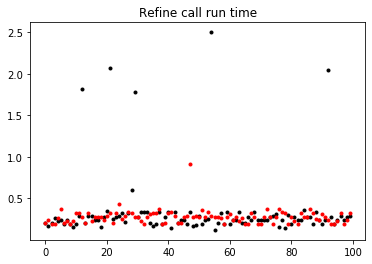

In [8]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')

Text(0.5, 1.0, 'Coarse call run time')

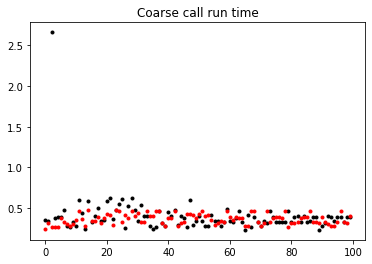

In [9]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


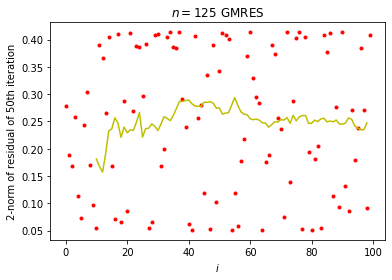

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

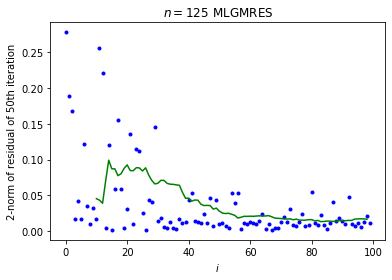

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

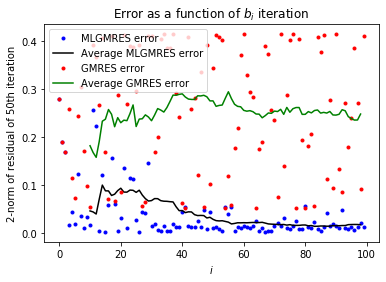

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

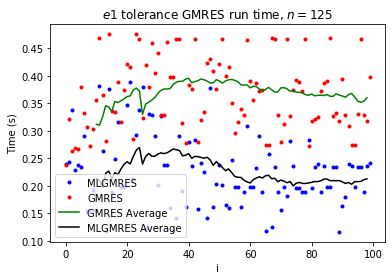

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')